In [120]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [131]:
n = 10  # number of tokens
d_model, d_attn, d_value = 5, 4, 5 # dm, da, dv
scale = 1.0 #/ np.sqrt(d_attn)
X = torch.randn(n, d_model)
Wq = torch.randn(d_model, d_attn)
Wk = torch.randn(d_model, d_attn)
Wv = torch.randn(d_model, d_value)

def self_attention(X, Wq, Wk, Wv, scale=1.0):
    Q = X @ Wq * scale # [n, da]
    K = X @ Wk * scale # [n, da]
    V = X @ Wv # [n, dv]
    scores = torch.einsum('il,jl->ij', Q, K) # or Q @ K^T; [n,n]              
    attn = torch.softmax(scores, axis=1) # [n,n]
    Y = torch.einsum('ij,jd->id', attn, V) # or A @ V; [n, dv]
    return Y

Y = self_attention(X, Wq, Wk, Wv, scale=scale)

In [132]:
Wk1 = torch.randn(d_model, d_attn)
Wk2 = torch.randn(d_model, d_attn)

def self_attention_3d(X, Wq, Wk1, Wk2, Wv):
    Q = X @ Wq # [n, da]
    K1 = X @ Wk1 # [n, da]
    K2 = X @ Wk2 # [n, da]
    V = X @ Wv # [n, dv]
    scores = torch.einsum('il,jl,kl->ijk', Q, K1, K2) # [n, n, n]
    attn = torch.softmax(scores.reshape(n, -1), dim=1).reshape(n, n, n) # [n, n, n]
    Vjk = torch.cat([V.unsqueeze(1)+V.unsqueeze(0)], dim=0) # [n, n, dv]
    Y = torch.einsum('ijk,jkd->id', attn, Vjk) # [n, dv]
    return Y

Y_3d = self_attention_3d(X, Wq, Wk1, Wk2, Wv)

In [141]:
def self_attention_rfa(X, Wq, Wk, Wv, m=100, eps=1e-6):
    Q = X @ Wq # [n, da]
    K = X @ Wk # [n, da]
    V = X @ Wv # [n, dv]

    Omega = torch.randn(d_attn, m, device=Q.device, dtype=Q.dtype)  # ω_r ~ N(0, I)

    # positive random features: phi(x) = exp(ω^T x - (alpha/2)||x||^2) / sqrt(m)
    Q_quad = 0.5 * (Q * Q).sum(dim=1, keepdim=True)     # [n,1]
    K_quad = 0.5 * (K * K).sum(dim=1, keepdim=True)     # [n,1]

    Phi_Q = torch.exp(Q @ Omega - Q_quad) / np.sqrt(m)       # [n, m]
    Phi_K = torch.exp(K @ Omega - K_quad) / np.sqrt(m)       # [n, m]

    # Precompute summaries over keys
    KV = Phi_K.T @ V                               # [m, dv]
    z  = Phi_K.T @ torch.ones(n, 1, device=Q.device, dtype=Q.dtype)  # [m,1]

    # Row-wise normalized output
    numer = Phi_Q @ KV                              # [n, dv]
    denom = Phi_Q @ z                                # [n, 1]
    Y = numer / (denom + eps)                        # broadcast row-wise
    return Y

Y_rfa = self_attention_rfa(X, Wq, Wk, Wv, m=1000)

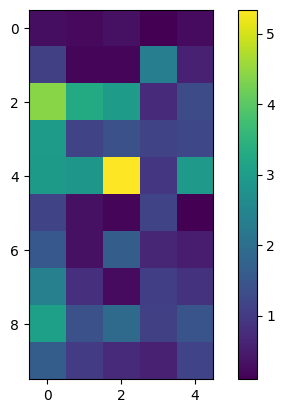

In [142]:
plt.imshow(torch.abs(Y_rfa - Y).detach().numpy())
plt.colorbar()

In [137]:
def rff_attention(X, Wq, Wk, Wv, sigma=1.0, N=1024, eps=1e-8):
    Q, K, V = X @ Wq, X @ Wk, X @ Wv
    Omega = torch.randn(Q.shape[1], N, device=X.device) / sigma

    def feat(T):
        TOm = T @ Omega
        phi = torch.cat([torch.cos(TOm), torch.sin(TOm)], -1) / N**0.5
        return phi * torch.exp((T * T).sum(-1, keepdim=True) / (2 * sigma**2))

    PhiQ, PhiK = feat(Q), feat(K)
    S = PhiK.T @ V
    z = PhiK.T @ torch.ones(X.shape[0], 1, device=X.device)
    return (PhiQ @ S) / ((PhiQ @ z) + eps)   # ≈ softmax(QK^T)V

Y_rff = rff_attention(X, Wq, Wk, Wv, sigma=1/scale, N=4096)

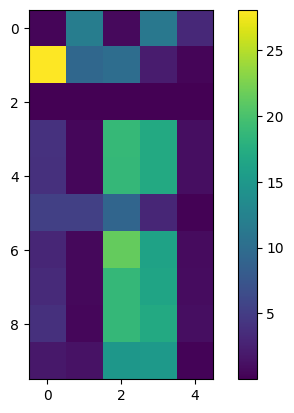

In [138]:
plt.imshow(torch.square(Y_rff - Y).detach().numpy())
plt.colorbar()